# PCG segmentation tutorial

## Setup steps

In [1]:
import pyPCG as pcg
import pyPCG.io as pcg_io
import pyPCG.preprocessing as preproc
import pyPCG.segment as sgm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

### Read in data and calculate envelope

In [2]:
from importlib.resources import files
data, fs = pcg_io.read_signal_file(str(files('pyPCG').joinpath("data").joinpath("example.wav")),"wav")
signal = pcg.pcg_signal(data,fs)

signal = pcg.normalize(signal)
bp_signal = preproc.filter(preproc.filter(signal,6,100,"LP"),6,20,"HP")
denoise_signal = preproc.wt_denoise(bp_signal)
env_signal = preproc.homomorphic(denoise_signal)

## Segmentation with peak detection

We can detect the heartsounds by detecting peaks in the envelope.

Usual `find_peaks` methods have problems with detecting heartsound peaks, even after proper paramtertization. This is why we use an adaptive and advanced method.

In [3]:
peakvals, peaks = sgm.adv_peak(env_signal)
print(len(peaks))

266


These detections contain both the S1 and S2 sounds.

We can diferentiate between them, with multiple ways. But the simplest is by comparing the time-differences between detections.

(Usually S1-S2 sections are shorter than S2-S1 sections)

In [4]:
s1,s2 = sgm.peak_sort_diff(peaks)

Then, for proper segmentation we need the starting and ending time of each heartsound. This is also possible with multiple methods.

Our implementation uses the envelope and detects a significant drop in value compared to the peak as the boundaries of the heartsound.

In [5]:
peak_s1_start,peak_s1_end = sgm.segment_peaks(s1,env_signal,start_drop=0.8,end_drop=0.7)

Let's visualize the result

(0.0, 2.0)

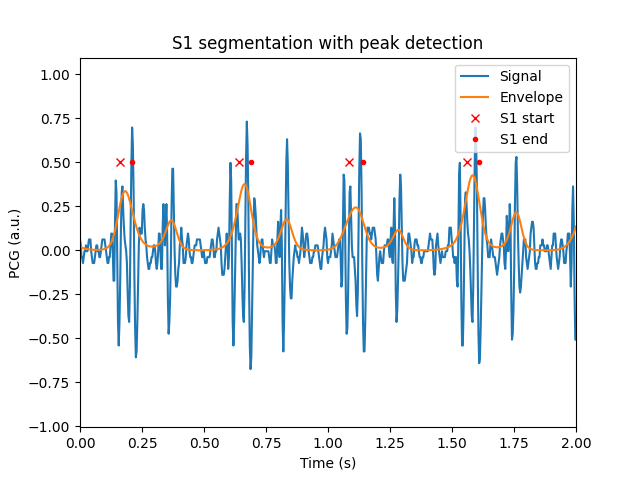

In [6]:
plt.figure()
pcg.plot(signal)
pcg.plot(env_signal)
plt.plot(peak_s1_start/signal.fs,np.ones_like(peak_s1_start)*0.5,'rx')
plt.plot(peak_s1_end/signal.fs,np.ones_like(peak_s1_end)*0.5,'r.')
plt.legend(["Signal","Envelope","S1 start","S1 end"])
plt.title("S1 segmentation with peak detection")
plt.xlim((0,2))

## Segmentation with LR-HSMM

Based on Springer *et al.*, a special HMM can be used to segment the PCG signal.

For this, first load a pre-trained model with compatible parameters.

Note: model training is not included yet

In [7]:
hsmm = sgm.load_hsmm("pre_trained.json")

This can be used directly to get the heartcycle states. Which is a vector with the same length as the input signal; its values are 1, 2, 3, 4 which correspond with S1, systole, S2, diastole states, respectively.

In [8]:
states = sgm.segment_hsmm(hsmm,signal)

We can illustrate this as:

(0.0, 2.0)

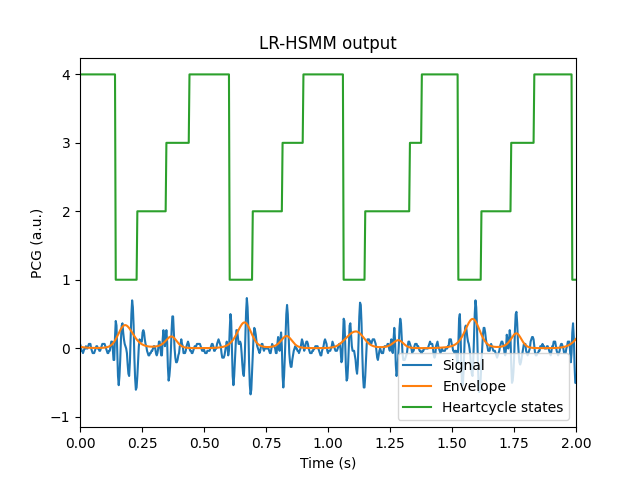

In [9]:
t = np.linspace(0,signal.get_timelength(),len(signal.data))
plt.figure()
pcg.plot(signal)
pcg.plot(env_signal)
plt.plot(t,states)
plt.legend(["Signal","Envelope","Heartcycle states"])
plt.title("LR-HSMM output")
plt.xlim((0,2))

For proper segmentation we can get the boundaries of a given state, like the following

In [10]:
hsmm_s1_start,hsmm_s1_end = sgm.convert_hsmm_states(states,sgm.heart_state.S1)

Visualize the results

(0.0, 2.0)

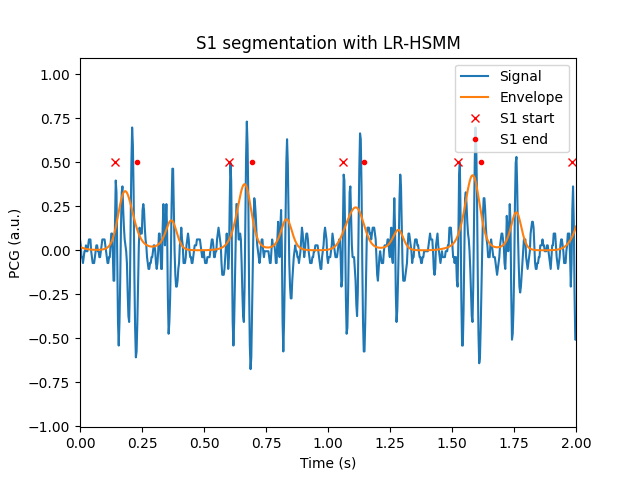

In [11]:
plt.figure()
pcg.plot(signal)
pcg.plot(env_signal)
plt.plot(hsmm_s1_start/signal.fs,np.ones_like(hsmm_s1_start)*0.5,'rx')
plt.plot(hsmm_s1_end/signal.fs,np.ones_like(hsmm_s1_end)*0.5,'r.')
plt.legend(["Signal","Envelope","S1 start","S1 end"])
plt.title("S1 segmentation with LR-HSMM")
plt.xlim((0,2))

## Final notes

Every later calculation on segments, such as feature extraction, reqires only the boundaries and the signal.

With this solution, we can segment for different heartsounds, systole-diastole regions, or even total heartcycles.<br>
If a given segment is not directly segmentable, it can be deduced from other boundaries. For example: a total heartcycle can be segmented by offsetting the S1-start array by one, and using it as the ending boundary.